# 0. Install Dependencies and Bring in Data

In [4]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
   creating: jigsaw-toxic-comment-classification-challenge/
   creating: jigsaw-toxic-comment-classification-challenge/sample_submission.csv/
  inflating: jigsaw-toxic-comment-classification-challenge/sample_submission.csv/sample_submission.csv  
   creating: jigsaw-toxic-comment-classification-challenge/test.csv/
  inflating: jigsaw-toxic-comment-classification-challenge/test.csv/test.csv  
   creating: jigsaw-toxic-comment-classification-challenge/test_labels.csv/
  inflating: jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv  
   creating: jigsaw-toxic-comment-classification-challenge/train.csv/
  inflating: jigsaw-toxic-comment-classification-challenge/train.csv/train.csv  


In [5]:
#tensorflow to create the sequential mode
#pandas to read the data
#matplotlib to plot the data
#sklearn to split the data
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [7]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

df.shape

(159571, 8)

# 1. Preprocess

In [8]:
!pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.4.0
accelerate                         1.2.1
aiohappyeyeballs                   2.4.4
aiohttp                            3.11.10
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.19
albumentations                     1.4.20
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.5.1
arviz                              0.20.0
astropy                            6.1.7
astropy-iers-data                  0.2024.12.16.0.35.48
astunparse                         1.6.3
async-timeout                      4.0.3
atpublic                           4.1.0
attrs                              24.3.0
audioread        

In [9]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [10]:
#all the comments
x = df['comment_text']
print(x)


0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object


In [11]:
#all the labels
y = df[df.columns[2:]].values
print(len(y))


159571


In [12]:
#Number of words in the vocab
MAX_WORDS = 20000

In [13]:
#Vectorize the text
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [14]:
type(x.values)

numpy.ndarray

In [15]:
#Learn the vocabulary from the text
vectorizer.adapt(x.values)

In [16]:
vectorizer('This is a project')[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 14,   9,   6, 463])>

In [17]:
#Vectorize the text
vectorized_text = vectorizer(x.values)

In [18]:
#The vectorized text of all the comments
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

In [19]:
# Pass the limited vectorized text and the labels to the dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [20]:
batch_x, batch_y= dataset.as_numpy_iterator().next()

In [21]:
len(dataset) #Number of batches


9974

In [22]:
int(len(dataset)*0.7) #Number of batches for training

6981

In [23]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [24]:
len(train), len(val), len(test)

(6981, 1994, 997)

# 2. Create Sequential Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [26]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))


In [27]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 673s 95ms/step - loss: 0.0908 - val_loss: 0.0509
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 678s 95ms/step - loss: 0.0489 - val_loss: 0.0429
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 666s 95ms/step - loss: 0.0430 - val_loss: 0.0398
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 671s 96ms/step - loss: 0.0389 - val_loss: 0.0340
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 664s 95ms/step - loss: 0.0358 - val_loss: 0.0321
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 691s 96ms/step - loss: 0.0327 - val_loss: 0.0293
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 667s 95ms/step - loss: 0.0306 - val_loss: 0.0274
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 661s 95ms/step - loss: 0.0276 - val_loss: 0.0243
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 685s 95ms/step - loss: 0.0254 - val_loss: 0.0230
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 664s 95ms/step - loss: 0.0231 - val_loss: 0.0199


In [29]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

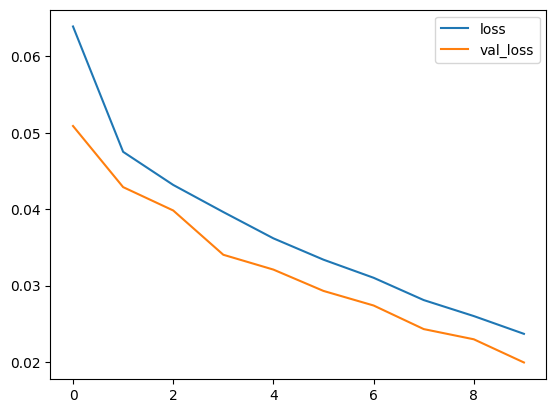

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [31]:
input_text1= vectorizer('I hate you. You are disgusting.')
input_text2= vectorizer('I love you. You are amazing.')
input_text3= vectorizer('Go kill yourself :)')
input_text4= vectorizer('You are the worst human being on earth. Fuck you!!!')
input_text5= vectorizer('You are a fucking retard you bitch')

In [32]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [41]:
model.predict(np.expand_dims(input_text4, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[9.9970680e-01, 1.8693702e-01, 9.9828821e-01, 2.1369490e-04,
        9.7701967e-01, 2.0685654e-02]], dtype=float32)

In [42]:
batch= test.as_numpy_iterator().next()

In [43]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [44]:
(model.predict(batch_x) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [46]:
res=model.predict(np.expand_dims(input_text1,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


# 4. Evaluate Model

In [47]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [52]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    x_true, y_true = batch
    # Make a prediction
    yhat = model.predict(x_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

In [53]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8984651565551758, Recall:0.8729566931724548, Accuracy:0.5245737433433533


# 5. Test and Gradio

In [54]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [55]:
import tensorflow as tf
import gradio as gr

In [56]:
model.save('toxicity.h5')

In [57]:
model = tf.keras.models.load_model('toxicity.h5')

In [58]:
input_str = vectorizer('hey i freaken hate you!')

In [59]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


In [60]:
res

array([[0.8617609 , 0.0145727 , 0.08188844, 0.07494695, 0.44011685,
        0.08660027]], dtype=float32)

In [61]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [62]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

In [63]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3e5c1f4c84d070797b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
